# (some) Related Work 
- A spectral Monte Carlo method for the Poisson equation
- Chebyshev Greeks Smoothing Gamma without Bias
- Approximation Theory and Approximation Practice (Lloyd N. Trefethen)
- Regression-based Monte Carlo Integration
- A new sequential algorithm for L2-approximation and application to Monte-Carlo integration (SALT)

We haven't looked into the literature for random ODEs (random start and coefficients not stochastic differential equations)

# Abstract
In this notebook we introduce a Monte Carlo technique for random ODEs, a SALT (orthonormal adaptive control variate) like algorithm, continue the discussion on how to turn ODEs into integral equations and make some related examples in code.

# Russian Roulette Modded
In period1 we missed a simple insight of Russian Roulette. Instead of killing of simulations completely you can substitute an approximation instead again without changing the expectance. This is similar to control variates both need approximations of the solution. <br>

To get our example in the code to work we did some algebra to figure out the modification:

In [4]:
from random import random
from math import exp

def approx_sol(t): return 1+t   

def Y(t):
    k = t if t<1 else 1
    return (1+t*Y(random()*t)-(1-k)*approx_sol(t))/k if random()<k else approx_sol(t)

t, nsim = 3,10**3

sol = sum(Y(t) for _ in range(nsim))/nsim

percentage_error = (sol - exp(t))/exp(t)

print(f"exp({t}) is approx = {sol},",f"%error = {percentage_error}")

exp(3) is approx = 20.473648200825806, %error = 0.019322922714109028


# RMC exp Dy
In period1 we weren't sure we could also recurse on the derivate of a the same order of the underlying differential equation. We show that it is possible with an example:

$$
y'= y+1, y(0)=1
$$
if we have a random variable $Y(t)$ such that $E[Y(t)]=y(t)$ from this we construct a random variable $DY(t)$ such that $E[DY(t)]= y'(t)$ in this case $DY(t) = Y(t) + 1$. <br>

Let's use this to make a recursive Monte Carlo scheme that also recurses on the derivative:
$$
\begin{align*}
y'      &= \frac{1}{2}y + \frac{1}{2}y' + \frac{1}{2} \Leftrightarrow \\
y (t)   &=  y(0) + \int_{0}^{t} \frac{1}{2}y(s) + \frac{1}{2}y'(s) + \frac{1}{2} ds\\
        &=  1 + t E \left[\frac{1}{2}y(U) + \frac{1}{2}y'(U) + \frac{1}{2} \right] \\
        &=  E \left[1 +  \frac{t}{2}Y(U) + \frac{t}{2}DY(U) + \frac{t}{2} \right] \\
\end{align*}
$$
This give following recursion relation for random variables:
$$
\begin{align*}
DY(t) &= Y(t) + 1 \\     
Y(t) &= 1+0.5tY(U) + 0.5tDY(U) + 0.5 t        
\end{align*}
$$
with $U = \text{Uniform}(0,t)$. We modified this with Russian Roulette in the implementation to make it non branching.

In [5]:
from random import random
from math import exp

#let t<1
def Y(t):
    if random()>t:
        return 1+0.5*t 
    s = random()*t
    return 1+ Y(s)  + 0.5*t if random()<0.5 else 1 + DY(s) + 0.5*t

def DY(t): return Y(t)+1
    
t,nsim = 0.8,10**3# t<1

sol = sum(Y(t) for _ in range(nsim))/nsim

s = 2*exp(t)-1 #analytic solution
percentage_error = (sol - s)/s

print(f"sol({t}) is approx {sol},",f"%error = {percentage_error}")

sol(0.8) is approx 3.320679434771674, %error = -0.03778595455489685


# Random ODEs
Let's get a quick example in (and maybe work out more later):
$$
y' = Ay, y(0)=1 , A = \text{Uniform}(0,1) 
$$
With solution $y(t)= e^{tA}$ which is a random variable. With the techniques we have right now we can simulate unbiased estimates of simulations of the solution (yeah randomness on randomness).With these you can get "weak" solutions ($E_y[f(y(t))]$ with $f$ analytic) to the problem: 
$$
\begin{align*}
E_y[f(y(t))] &= E_y[E_A[f(y(t)) \mid  A]] \\    
           &= E_y[E_A[f(y(t,A))]] \\    
            &= E_y[E_A[f(E_Y[Y(t,A)])]] \\
\end{align*}
$$
remember how we dealt with $f(E_Y[Y(t,A)])$ in period1? This makes things like unbiased estimators of the expectance and variance possible which can be used to get confidence intervals using Chebychev's inequality (https://en.wikipedia.org/wiki/Chebyshev%27s_inequality). <br>

In our example we can find the following by hand:
$$
\begin{align*}
E_A[y(t)] &=  \frac{e^{t}}{t} - \frac{1}{t} \\ 
E_A[y^{2}(t)] &=  \frac{e^{2t}}{2t} - \frac{1}{2t}  
\end{align*}
$$
In code all this looks like this:

In [14]:
from random import random
from math import exp,sqrt

#estimator for y(t,a)
def Ya(t,a):
    return (1+a*Ya(random()*t,a) if random()<t else 1) if t<1 else 1+t*a*Ya(random()*t,a)

# estimator for y(t)
def Y(t): return Ya(t,random())
    
# estimator for y(t)**2
def Y2(t):
    A = random()
    return Ya(t,A)*Ya(t,A) 

t,nsim = 3,10**4

sol = sum(Y(t) for _ in range(nsim))/nsim
sol2 = sum(Y2(t) for _ in range(nsim))/nsim


s =  exp(t)/t -1/t #analytic solution
percentage_error = (sol - s)/s

s2 =  exp(2*t)/(2*t) -1/(2*t) #analytic solution
percentage_error2 = (sol2 - s2)/s2

print(f"E(y({t}))   is approx {sol},",f"%error = {percentage_error}")
print(f"E(y^2({t})) is approx {sol2},",f"%error = {percentage_error2}")

sd = sqrt(sol2-sol**2)
print(f"standard deviation of y(3) is approx (biased) {sd}")

E(y(3))   is approx 6.316929656338214, %error = -0.007060212909667622
E(y^2(3)) is approx 67.10559389527508, %error = 0.000508835059087496
standard deviation of y(3) is approx (biased) 5.215553049500105


# From ODEs to Integral Equations (continuation)
We continue our discussion on how to turn ODEs into integral equations. Let's start from following form:
$$
L(y)= f 
$$ 
where $L$ is a linear operator, $f$ be generic for now and some initial/boundary condition for $y$. All the methods we have in mind are some kind of integral transform:
$$
y(t) = \int_{\Omega} \varphi(x) K(t,x)dx
$$
where the integral may also be a summation and we may chose $K(t,x), \Omega$ and let $\varphi(x)$ be our new unknown. Note that we don't know that such representation exist or even is well defined but we continue and fix this in the future (hopefully). If you sub this into the first equation you obtain the following:

$$
\begin{align*}
L \left(\int_{\Omega} \varphi(x) K(t,x)dx \right) &= f \Leftrightarrow \\
\int_{\Omega} \varphi(x) L \left(K(t,x) \right)dx &= f 
\end{align*}
$$ 

this is a Fredholm integral equation of the first type in $\varphi(x)$ (https://en.wikipedia.org/wiki/Fredholm_integral_equation) if we had let $\Omega$ depend on $t$ in a certain way we would have obtained a Voltera integral equation of the second kind (https://en.wikipedia.org/wiki/Volterra_integral_equation). <br> 

## Source Green Function 
Let's derive the method of source green functions in this framework (https://en.wikipedia.org/wiki/Green%27s_function). This can be done by choosing the free things in a way something nice happens: 
$$
L \left(K(t,x) \right) = \delta(t-x)
$$

with the same  domain and initial/boundary conditions such that the ones of $y$ hold. Choosing the initial/boundary conditions that way is easy but not trivial. <br> 

For a dirichlet boundary condition in $s$ the following can be done:
$$
\begin{align*}
y(s) &= \int_{\Omega} \varphi(x) K(s,x)dx \Leftarrow \\
K(s,x) &= \frac{y(s) l(x)}{\varphi(x)} \text{ and } 1 = \int_{\Omega}l(x)dx  
\end{align*}
$$
For a Neumann boundary condition in $s$ the following can be done:

$$
\begin{align*}
y'(s) &= \int_{\Omega} \varphi(x) K'(s,x)dx \Leftarrow \\
K'(s,x) &= \frac{y'(s) l(x)}{\varphi(x)} \text{ and } 1 = \int_{\Omega}l(x)dx  
\end{align*}
$$

with $l$ arbitrary. Linear type of initial/boundary conditions are very similar to this. The $\varphi = f$ in the initial/boundary condition is annoying but can be avoided by making the original initial/boundary condition $0$ by splitting explained in period1. <br>

Going back because of our choice the following thing can be derived

$$
\begin{align*}
\int_{\Omega} \varphi(x) L \left(K(t,x) \right)dx &= f \Leftrightarrow \\
\int_{\Omega} \varphi(x) \delta(t-x)dx &= f \Leftrightarrow \\
\varphi(t) &= f 
\end{align*}
$$ 

## Boundary Green Function
Boundary Green functions deals with boundary conditions like how source Green functions deals with the source. The intuition behind them is the same as the solutions of a linear homogenous ODE that span a vector space. 

$$
y(t)= \int_{\partial B} \varphi(x) K(t,x) dx
$$

If you impose $L(y(t)) = 0$ on this you get the following:

$$
\begin{align*}
\int_{\partial B} \varphi(x) L(K(t,x)) dx &= 0 \Leftarrow \\
L(K(t,x))  &= 0 
\end{align*}
$$
Again the initial conditions on $K(t,x)$ come from the original problem: 

For a dirichlet boundary condition in $s$ the following can be done:
$$
\begin{align*}
y(s) &= \int_{\partial \Omega} \varphi(x) K(s,x)dx \Leftarrow \\
K(s,x) &= \delta(x-s) \text{ and } \varphi(s)= y(s) 
\end{align*}
$$
Other linear type initial/boundary conditions are very similar.

## Fixed Integral Transforms
In the Green function method we searched an integral transform with a certain property related to the equation that we were solving. Certain classes of integral transformations have nice properties for a big class of equations. A classic integral transform used for ODEs is the Fourier transform (https://en.wikipedia.org/wiki/Fourier_transform). But we haven't figured out how to deal with boundary conditions in this case.

## Series Transforms
The discrete version of an integral transform is a series transform, in which you transfer information about the function to $\varphi_n$.
$$
y(t) = \sum_{n=0}^{\infty} \varphi_n e_n(t) 
$$
our original equation with this becomes:
$$
\begin{align*}
L \left(\sum_{n=0}^{\infty} \varphi_n e_n(t) \right) &= f \Leftrightarrow \\
\sum_{n=0}^{\infty} \varphi_n L (e_n(t)) &= f 
\end{align*}
$$
Again there a lot of tricks you can pull of with this. A convenient thing is when $L(e_{n}(t)) = \phi_{n}$ (and $e_{n}$ spans the space of functions which follow the initial/boundary conditions) is bi-orthogonal basis against some $\psi_n$  $\left(\langle \phi_j \mid \psi_{k} \rangle= \delta_{jk}\right)$ .

$$
\begin{align*}
\sum_{n=0}^{\infty} \varphi_n \phi_{n} &= f \Rightarrow \\
\left \langle \sum_{n=0}^{\infty} \varphi_n \phi_{n}\mid \psi_{j}  \right \rangle &=  \langle f\mid \psi_{j} \rangle \Leftrightarrow  \\
\sum_{n=0}^{\infty} \varphi_n \left \langle \phi_{n}\mid \psi_{j}  \right \rangle &=  \langle f\mid \psi_{j} \rangle \Leftrightarrow \\
\sum_{n=0}^{\infty} \varphi_n \delta_{nj} &=  \langle f\mid \psi_{j} \rangle \Leftrightarrow \\
\varphi_j &=  \langle f\mid \psi_{j} \rangle 
\end{align*}
$$
This means we have following expression for the solution:
$$
\begin{align*}
y(t) &= \sum_{n=0}^{\infty} \langle f(x)\mid \psi_{n}(x) \rangle e_{n}(t)  \Leftrightarrow\\
y(t) &= \left\langle f(x)\mid  \sum_{n=0}^{\infty} \psi_{n}(x)e_{n}(t)  \right \rangle 
\end{align*}
$$ 
this expression in some cases depending on how the inner product is defined corresponds with the Green function $G(t,x) =\sum_{n=0}^{\infty} \psi_{n}(x)e_{n}(t)$. <br>

Related wikipedia page : https://en.wikipedia.org/wiki/Spectral_theory_of_ordinary_differential_equations
## Others
This is probably not the only way to turn ODEs into integral equations. The Feynman-Kac formula https://en.wikipedia.org/wiki/Feynman%E2%80%93Kac_formula is derived in an other way but still kind of obeys the general form we have given.

## Practical Stuff
There are multiple ways to turn problems into integral equations for Monte Carlo methods but not all those integral equations gives you Monte Carlo methods with the same properties. Things like: the type of the domain chosen, stochastic approximations made, what gets thrown to the source term and what needs to be recursed on determine the properties of the Monte Carlo method obtained. <br>  

Each Monte Carlo method doesn't have to be limited to $1$ integral equation. One may use a different integral equation for each recursion step made in combination with the different modifications discussed in period1. This makes for a big search space of possible Monte Carlo algorithms. <br>


Another thing to take in consideration is that finding Green functions is difficult a way around that is by throwing everything in the source term but by doing this you probably lose good properties. This approach is taken for example in Grid-Free Monte Carlo for PDEs with Spatially Varying Coefficients.

## Example
To test that boundary Green functions work for ODEs we work out following example:
$$
y'' = y, y(0) = 1, y'(1)=e
$$
with solution $y(t) = e^{t}$. We chose the splitting Green function method with $\Omega = [-1,1],f = y$ as discussed as before. <br>

Let's create integral representation of the boundary and source terms separately:
### Source Term
$$
y''_{s} = f \text{ with } y_s(0)=0, y'_s(1)=0
$$
And the equation for the corresponding Green function:
$$
G''(t,x) = \delta(t-x) \text{ with } G(0,x)=0, G'(1,x)=0
$$
$G$ must be something continuos piecewise linear with a jump of $1$ in the derivative at $t = x$.
By some algebra we find following solution:
$$
G(t,x) =
\begin{cases}
 -t & \text{if } t <  x \\
 -x& \text{if } t \ge  x 
\end{cases}
$$ 
Write out the solution for $y_{s}(t)$:
$$
y_{s}(t) = \int_{0}^{1} y(x) G(t,x) dx.
$$

### Boundary Term
We still have some problems to fix with the boundary Green functions ... <br>
The boundary in for ODEs is discrete $\partial \Omega = \{0,1\}$. So instead of an integral we have sum and Green function also splits into $2$...

$$
y''_{b} = 0 \text{ with } y_{s}(0)=1, y'_{s}(1)= e
$$ 
Let's call the boundary function $K$ so that we don't confuse it with $G$. So we have $K(t,0)$ and $K(t,1)$.The solution for these are easily found: 

$$
\begin{align*}
K''(t,0)&= 0 \text{ with } K(0,0)=1, K'(0,1)=0 \Rightarrow \\
K(t,0)&=1 
\end{align*}
$$ 

$$
\begin{align*}
K''(t,1)&=0 \text{ with } K(1,0)=0, K'(1,1)=1 \Rightarrow \\
K(t,1)&=t 
\end{align*}
$$

Write out the solution for $y_{b}(t)$:
$$
y_{b}(t) = 1 + e t 
$$

### Putting Everything Together
If you put everything together you get:
$$
y(t) = 1+et +\int_{0}^{1} y(x) G(t,x)dx.
$$ 
In the implementation we use Russian Roulette  with probability $1-\frac{1}{1.3}$ always for stopping.
In code this looks like:

sol(0.5) is approx 1.7029020971931288, %error = 0.03286233243657538


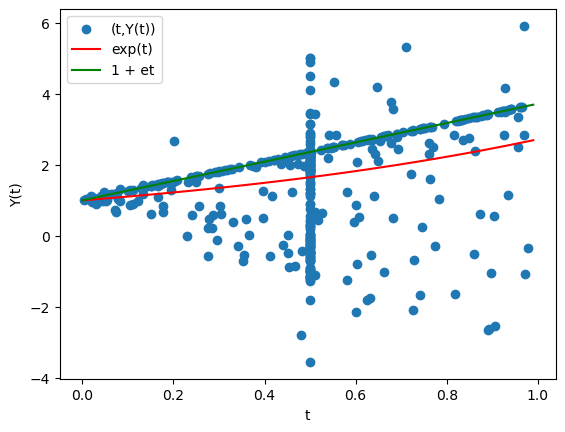

In [1]:
from random import random
import numpy as np
from math import exp,sqrt
import matplotlib.pyplot as plt

def G(t,x): return -t if t<x else -x 

memo = []
def Y(t):
    u=random()
    res = 1+ exp(1)*t +2*(Y(u)*G(t,u)) if random()<1/2 else 1+ exp(1)*t 
    memo.append((t,res))
    return res
    

t,nsim = 0.5,3*10**2 # t<1

sol = sum(Y(t) for _ in range(nsim))/nsim

s = exp(t) #analytic solution
percentage_error = (sol - s)/s

print(f"sol({t}) is approx {sol},",f"%error = {percentage_error}")
xs,ys = zip(*memo)
ll =  np.arange(0,1,0.01)
zs = [exp(x) for x in ll]
qq = [1 + exp(1)*t for t in ll]

plt.scatter(xs,ys, label= "(t,Y(t))")
plt.plot(ll,zs, color="red", label="exp(t)")
plt.plot(ll,qq, color= "green", label="1 + et")
plt.xlabel("t")
plt.ylabel("Y(t)")
plt.legend()
#plt.title(f"recursion points of Y({t})")
# plt.savefig("../latex/main paper/plots/ddyy.png",dpi=300)
plt.show()

The plot of recursion points is a great to visualize uncertainty of the solution. <br> 
Here is where we going to leave it at for ODEs to integral equations for period2. Later we maybe look into how to use approximate green functions or incomplete orthonormal basis's to enhance performance in the sense of approximate inverses of the linear operator. We haven't yet discussed about how to deal with complex domains but half of the answer can be found in Grid-Free Monte Carlo for PDEs with Spatially Varying Coefficients the missing part is how to recurse on the boundary with special boundary conditions (which is pretty straight forward but we haven't made an example for it yet...).

# Adaptive Control Variates
To make Monte Carlo simulations faster we will rely on adaptive control variates. Adaptive control variates were already mentioned in period1. We will focus on orthonormal adaptive control variates because of their simplicity in implementation and theory. In the literature we found SALT (sequential algorithm L two norm) (A new sequential algorithm for L2-approximation and application to Monte-Carlo integration) that used the same ideas. <br>

As seen in period1 we can construct control variates based on approximate solutions (see tests for more details). A general way to find approximate solutions is to use stochastic optimization methods like described in (Regression-based Monte Carlo Integration (we don't like this paper)) but this raises issues like getting stuck in local minima and stuff. Using an orthonormal basis to approximate the solution sidesteps all those problems and we can derive an algorithm without using any stochastic optimization theory. The stochastic optimization perspective is important because it is broader then orthonormal theory one can do interesting things like imposing constraints ... and you're not limited to orthonormal basis's.  <br>

A measure of goodness of a approximate solution to make a control variate of it is the $L_2$ norm 
(see tests for more details).
$$
\text{min}||f-\tilde{f}||_{2}
$$ 

if we have orthonormal basis of the complete space where $f$ lives we can use Hilbert projection theorem (https://en.wikipedia.org/wiki/Hilbert_projection_theorem) to make the best approximation in the sub Hilbert spaces spanned by finite subset of the orthonormal basis. We will focus on orthonormal polynomials (we used Legendre polynomials). With some orthonormal theory you can find the best approximation by calculating inner products:

$$
\begin{align*}
\tilde{f}_{k}(x) &= \sum_{n=0}^{k} a_n \phi_{n}(x) \\
a_{n} &= \int_{-1}^{1}f(x) \phi_{n}(x) dx
\end{align*}
$$ 
We can get unbiased estimator of the last integral via Monte Carlo using the current $\tilde{f}$ as control variate. This lead to a positive feedback loop where better approximations lead to better estimates and vice versa. <br>

## Robustness Example
In higher dimensions where geometry of the integration domain can be complex it is difficult to construct an orthonormal basis. Using an approximate orthonormal basis instead will help alleviate stochastic optimization problems. To test this we made following code example with Legendre polynomials (without 1) where orthogonality are approximately met:

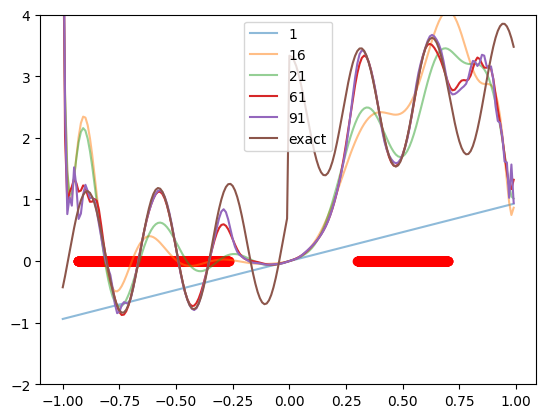

In [356]:
from random import random 
import matplotlib.pyplot as plt
import numpy as np
from math import exp, cos

#legendre polynomials p(x,0)= x (which is wrong ...)
def p(x,n):
    pl,pll = x,1
    for j in range(n):
        pl,pll = ((2*j+1)*x*pl-j*pll )/(j+1),pl
    return pl
        
def f(x):
    return exp(x)/3 + cos(20*x-1) if x<0 else exp(x)/3 + cos(20*x) +2

# can be more efficient using Clenshaw algorithm (https://en.wikipedia.org/wiki/Clenshaw_algorithm)
def approx_sol(a_control,x):
    return sum(a_control[j]*p(x,j)for j in range(len(a_control)))

tmp= []
def a_all(a_control,nsim=10):
    sol = [0]*len(a_control)
    for _ in range(nsim):
        u = (random()*2-1)/3.0 -0.6 if random()<0.5 else (random()*2-1)/5 +0.5 # some weird domain
        tmp.append(u)
        ps = [p(u,j) for j in range(len(a_control))]
        aasol = sum(a*p for a,p in zip(a_control,ps)) 
        w =(0.5*u+1.5) # random weight that shouldnt be here
        ff = f(u)
        for n in range(len(a_control)):
            sol[n] += ((2*n+1)*(ff+(random()-0.5)/2-aasol)*ps[n]*w + a_control[n])/nsim
    return sol

a_control = [0]
order = 101
xs = np.arange(-1,1,0.01)

#we gradually add more and more coefficient you can think of it as somekind of regularization
while len(a_control)<order:
    o = len(a_control)
    a_control = a_all(a_control,50 if o<20 else (80 if o<40 else 250)) 
    #the reason why higher orders need more simulations is because the we added a fixed variance to f
    if random()<1/5 or order-20<o:
        ys2 = [approx_sol(a_control,x) for x in xs]
        c = 0.5 if o/order<0.3 else(0.8 if o/order<0.6 else 1)
        plt.plot(xs, ys2,label=o, alpha = c)
    for _ in range(2 if o<10 else (5 if o<40 else 10)):
        a_control.append(0)
        
ys1 = [f(x) for x in xs]

plt.scatter(tmp,[0]*len(tmp), color ="red")
plt.plot(xs, ys1,label= "exact")
plt.legend()
plt.ylim(-2,4)
plt.show()

Near boundaries the accuracy drops.

## ODE Example
The problem from previous example:
$$
y''=y, y(0)=1,y'(1)=e
$$ 
this lead to 
$$
y(t) = 1+et +\int_{0}^{1} y(x) G(t,x)dx.
$$ 
if we have an approximate solution in a decomposition with scaled Legendre polynomials:  $\tilde{y}=\sum_{n=1}^{k} a_n \phi_{n}$ we can use that in an control variate strategy:  
$$
\begin{align*}
y(t)&= 1+et +\int_{0}^{1} y(x) G(t,x)dx \\
    &= 1+et +\int_{0}^{1} (y(x)-\sum a_n \phi_{n}(2x-1)+\sum a_n \phi_{n}(2x-1)) G(t,x)dx\\
    &= 1+et +\int_{0}^{1} (y(x)-\sum a_n \phi_{n}(2x-1))G(t,x)dx+\int_{0}^{1} \sum a_n \phi_{n}(2x-1) G(t,x)dx\\
\end{align*}
$$ 
 The new integral we also calculate with Monte Carlo and we may subtract $t$ from $G$for all $n>1$ as a control variate for it because Legendre have $0$ integrals. 

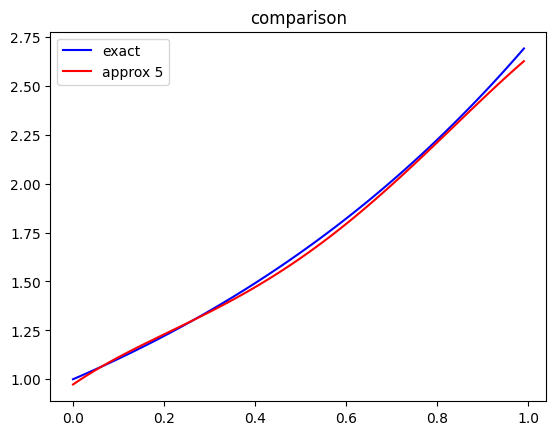

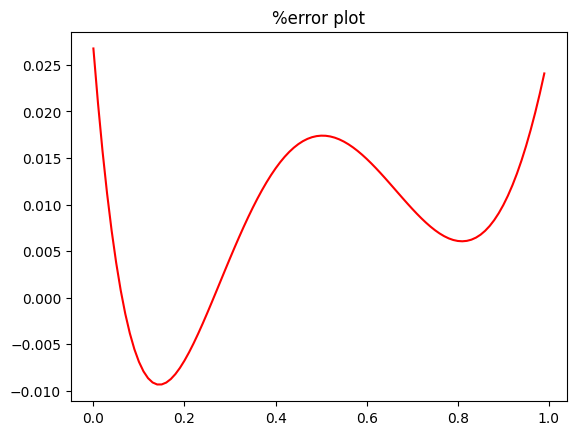

In [25]:
from random import random
import matplotlib.pyplot as plt
import numpy as np
from math import exp
from functools import lru_cache

@lru_cache(maxsize=3) #legendre polynomials 
def p(x,n): return ((2*n-1)*x*p(x,n-1)-(n-1)*p(x,n-2))/n if n>1 else (x if n ==1 else 1)

# can be more efficient using Clenshaw algorithm (https://en.wikipedia.org/wiki/Clenshaw_algorithm)
def approx_sol(a_control,x):
    return sum(a_control[j]*p(x,j)for j in range(len(a_control)))

def scale_down(x): return (x+1)/2 # from [-1,1] to [0,1]
def scale_up(x): return 2*x-1 # from [0,1] to [-1,1]

def G(t,x): return -t if t<x else -x 

# Monte carlo estimate for the second integral
def I2(t,nsim, a_control):
    sol = 0
    for _ in range(nsim):
        u = random()
        sol += approx_sol(a_control,scale_up(u))*G(t,u)/nsim
    return sol 

def Y(t, a_control, pkill = 0.5,MCs=1):
    if random()>pkill: 
        u = random()
        res = 1+ exp(1)*t + (Y(u,a_control,pkill)-approx_sol(a_control,scale_up(u)))*G(t,u)/(1-pkill) + I2(t,MCs,a_control)
    else:
        res =  1+ exp(1)*t + I2(t,MCs,a_control)
    return res

def YY(t,a_control,pkill=0.5,MCs=1,nsim=1):
    sol =0
    for _ in range(nsim):
        sol += Y(t,a_control,pkill,MCs)/nsim
    return sol
    
def a_all(a_control,nsim=10):
    sol = [0]*len(a_control)
    for _ in range(nsim):
        u = (random()*2-1)
        ps = [p(u,j) for j in range(len(a_control))]
        aasol = sum(a*p for a,p in zip(a_control,ps)) 
        ff = YY(scale_down(u),a_control,0.1,1,len(a_control))
        for n in range(len(a_control)):
            sol[n] += ((2*n+1)*(ff-aasol)*ps[n] + a_control[n])/nsim 
    return sol

order,a_control = 5, [0]

#we gradually add more and more coefficient you can think of it as somekind of regularization
while len(a_control)<order+1:
    o = len(a_control)
    a_control = a_all(a_control,5*10**2) 
    a_control.append(0)

xs = np.arange(0,1,0.01)
ys = [exp(x) for x in xs]
zs = [approx_sol(a_control,scale_up(x)) for x in xs]
plt.plot(xs,ys, color= "blue",label="exact")
plt.plot(xs,zs, color= "red", label=f"approx {order}")
plt.title("comparison")
plt.legend()
plt.show()

xs = np.arange(0,1,0.01)
zs = [(exp(x)-approx_sol(a_control,scale_up(x)))/exp(x) for x in xs]
plt.plot(xs,zs, color= "red", label=f"approx {order}")
plt.title("%error plot")
plt.show()

There are some things that still have to be done in this example:
- using every recursion call: right now we only call $Y(t)$ and use its result instead we could have used every recursion call of $Y(t)$
- correcting for the boundary: we have full knowledge of some behavior at the boundaries but we haven't used it + polynomial fits have bad behavior near boundaries
- Instead of MC control variates the use of analytical ones will add efficiency this can be achieved by using a smart set of basis functions related to the $L,G$ used for the integral equation <br>

Chapter 5 of statistical learning also talks about function fitting where similar problems get encountered. 

# TODO
- an example of Monte Carlo for non diffusive PDE
- inverse problems
- local models via SALT as a replacement for the greeks